# Analysis of ProB backend over the 275 features set

In this note book we will explore the ProB native backend with default settings over the F275 feature set by employing decision trees and random forests.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/2019-12-04/prob-f275_unique.csv')
data.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature266,Feature267,Feature268,Feature269,Feature270,Feature271,Feature272,Feature273,Feature274,Label0
0,100.0,0.06,0.19,0.02,0.105263,0.06,0.13,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,100.0,0.06,0.19,0.03,0.157895,-0.86,1.05,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,100.0,0.06,0.20,0.02,0.100000,0.07,0.12,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100.0,0.06,0.20,0.03,0.150000,-0.87,1.06,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,100.0,0.06,0.20,0.04,0.200000,0.07,0.12,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Data insights

Firstly, we check how many positive and negative samples exist in the data.

In [2]:
sample_count = len(data)
positive = data[data["Label0"] == 1]
negative = data[data["Label0"] == 0]

print("We have %d samples in the dataset." % sample_count)
print("For %d of these, ProB is able to find a solution (%0.3f%%)" % (len(positive), len(positive)/sample_count))
print("For %d of these, ProB is _not_ able to find a solution (%0.3f%%)" % (len(negative), len(negative)/sample_count))

We have 106230 samples in the dataset.
For 95750 of these, ProB is able to find a solution (0.901%)
For 10480 of these, ProB is _not_ able to find a solution (0.099%)


Text(0, 0.5, '# Samples')

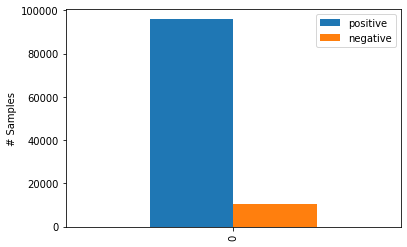

In [3]:
%matplotlib inline

class_balance = pd.DataFrame(data={"positive": [len(positive)], "negative": [len(negative)]})
class_balance_plot = class_balance.plot(kind="bar")
class_balance_plot.set_ylabel("# Samples")

Now we will inspect how often each feature is used in the data in the first place. Thus we can evaluate how much significance each evaluation over the subdomains has.

In [4]:
feature_uses = data[data > 1e-7].count() # For some values, 1e-7 is the lowest instead of 0.
rel_feature_uses = feature_uses/sample_count

fd = {}
for f in range(275):
    fd["Feature%d" % f] = [feature_uses[f]]
feature_data = pd.DataFrame(data=fd)
feature_data

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature265,Feature266,Feature267,Feature268,Feature269,Feature270,Feature271,Feature272,Feature273,Feature274
0,106230,106230,88271,88271,88271,77213,75919,88446,18776,106152,...,206,0,136,8,2,0,545,22,545,22


In [5]:
# We also calculate the relative amount of feature uses.
fd = {}
for f in range(275):
    fd["Feature%d" % f] = [rel_feature_uses[f]]
rel_feature_data = pd.DataFrame(data=fd)
rel_feature_data

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature265,Feature266,Feature267,Feature268,Feature269,Feature270,Feature271,Feature272,Feature273,Feature274
0,1.0,1.0,0.830942,0.830942,0.830942,0.726847,0.714666,0.83259,0.176749,0.999266,...,0.001939,0.0,0.00128,0.000075,0.000019,0.0,0.00513,0.000207,0.00513,0.000207


In [6]:
data.groupby("Label0").mean()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature265,Feature266,Feature267,Feature268,Feature269,Feature270,Feature271,Feature272,Feature273,Feature274
Label0,,,,,,,,,,,,,,,,,,,,,
0,10.416221,1.755806,0.340443,0.287682,0.559232,26.505638,1.454835,4.018525,0.390720,32.369717,...,0.003220,0.0,0.001240,0.000000,0.000000,0.0,0.008779,0.001622,0.003096,0.000620
1,11.663070,1.216280,0.478940,0.372724,0.711640,6.759599,2.100983,1.905493,0.191821,10.957896,...,0.001717,0.0,0.001285,0.000084,0.000021,0.0,0.007781,0.000115,0.003232,0.000089


## Decision Trees

Let's run a quick check how good a decision tree can perform on the data.

### Prepare the training and test data

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2)
train_x = train[train.columns[0:275]]
train_y = train["Label0"]

test_x = test[test.columns[0:275]]
test_y = test["Label0"]

### Train and evaluate

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

tree = DecisionTreeClassifier(class_weight="balanced")

tree.fit(train_x, train_y)

train_acc = metrics.accuracy_score(tree.predict(train_x), train_y)
test_acc = metrics.accuracy_score(tree.predict(test_x), test_y)
print("Train accuracy: %0.3f; test accuracy: %0.3f" % (train_acc, test_acc))

train_bacc = metrics.balanced_accuracy_score(tree.predict(train_x), train_y)
test_bacc = metrics.balanced_accuracy_score(tree.predict(test_x), test_y)
print("Train balanced accuracy: %0.3f; test balanced accuracy: %0.3f" % (train_bacc, test_bacc))

train_prec = metrics.precision_score(tree.predict(train_x), train_y)
test_prec = metrics.precision_score(tree.predict(test_x), test_y)
print("Train precision: %0.3f; test precision: %0.3f" % (train_prec, test_prec))

train_rec = metrics.recall_score(tree.predict(train_x), train_y)
test_rec = metrics.recall_score(tree.predict(test_x), test_y)
print("Train recall: %0.3f; test recall: %0.3f" % (train_rec, test_rec))

train_f1 = metrics.f1_score(tree.predict(train_x), train_y)
test_f1 = metrics.f1_score(tree.predict(test_x), test_y)
print("Train F1: %0.3f; test F1: %0.3f" % (train_f1, test_f1))

Train accuracy: 0.989; test accuracy: 0.918
Train balanced accuracy: 0.948; test balanced accuracy: 0.770
Train precision: 0.987; test precision: 0.953
Train recall: 1.000; test recall: 0.956
Train F1: 0.994; test F1: 0.954


## Random Forest and Gini Importance

Next we will rain a random forest with Gini Impurity and calculate the respective gini importances of each feature.

In [9]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators=100, # 100 Trees.
    criterion="gini", # Using Gini index instead of "entropy"
    n_jobs=6, # Number of CPUs to use.
    bootstrap=False,
    max_features=0.7,
    random_state=123,
    class_weight="balanced")

forest.fit(train_x, train_y)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [10]:
train_acc = metrics.accuracy_score(forest.predict(train_x), train_y)
test_acc = metrics.accuracy_score(forest.predict(test_x), test_y)
print("Train accuracy: %0.3f; test accuracy: %0.3f" % (train_acc, test_acc))

train_bacc = metrics.balanced_accuracy_score(forest.predict(train_x), train_y)
test_bacc = metrics.balanced_accuracy_score(forest.predict(test_x), test_y)
print("Train balanced accuracy: %0.3f; test balanced accuracy: %0.3f" % (train_bacc, test_bacc))

train_prec = metrics.precision_score(forest.predict(train_x), train_y)
test_prec = metrics.precision_score(forest.predict(test_x), test_y)
print("Train precision: %0.3f; test precision: %0.3f" % (train_prec, test_prec))

train_rec = metrics.recall_score(forest.predict(train_x), train_y)
test_rec = metrics.recall_score(forest.predict(test_x), test_y)
print("Train recall: %0.3f; test recall: %0.3f" % (train_rec, test_rec))

train_f1 = metrics.f1_score(forest.predict(train_x), train_y)
test_f1 = metrics.f1_score(forest.predict(test_x), test_y)
print("Train F1: %0.3f; test F1: %0.3f" % (train_f1, test_f1))


Train accuracy: 0.989; test accuracy: 0.931
Train balanced accuracy: 0.948; test balanced accuracy: 0.815
Train precision: 0.987; test precision: 0.969
Train recall: 1.000; test recall: 0.955
Train F1: 0.994; test F1: 0.962


Let's map out the corresponding feature importances. We start by making use of the example code from [sk-learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [11]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 211 (0.125816)
2. feature 5 (0.059218)
3. feature 209 (0.038141)
4. feature 108 (0.024102)
5. feature 6 (0.020634)
6. feature 3 (0.020208)
7. feature 91 (0.019579)
8. feature 20 (0.019380)
9. feature 92 (0.019261)
10. feature 4 (0.018845)
11. feature 55 (0.018263)
12. feature 45 (0.018063)
13. feature 109 (0.017439)
14. feature 74 (0.016778)
15. feature 7 (0.016049)
16. feature 2 (0.015919)
17. feature 21 (0.015643)
18. feature 76 (0.015329)
19. feature 9 (0.014440)
20. feature 37 (0.013206)
21. feature 106 (0.011923)
22. feature 221 (0.011437)
23. feature 190 (0.011302)
24. feature 30 (0.011301)
25. feature 34 (0.010807)
26. feature 110 (0.010481)
27. feature 22 (0.010356)
28. feature 26 (0.010105)
29. feature 13 (0.009829)
30. feature 10 (0.009223)
31. feature 65 (0.008792)
32. feature 93 (0.008657)
33. feature 1 (0.008448)
34. feature 29 (0.008198)
35. feature 17 (0.008181)
36. feature 180 (0.008160)
37. feature 44 (0.008130)
38. feature 170 (0.007642)
39

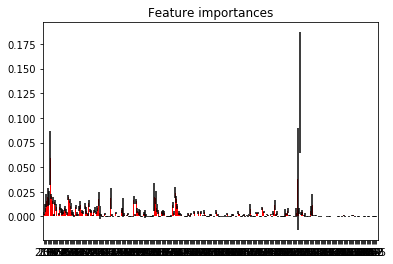

In [12]:
# Plot the feature importances of the forest
import matplotlib.pyplot as plt

plt.figure()
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), importances,
       color="r", yerr=std, align="center")
plt.xticks(range(train_x.shape[1]), indices)
plt.xlim([-1, train_x.shape[1]])
plt.show()

### Training on the full data set

For the feature evaluation it might be more of interest to not exclude the test set from the training data as we should account for all the data we have.

In [13]:
X = data[data.columns[0:275]]
Y = data["Label0"]

fforest = RandomForestClassifier(
    n_estimators=100, # 100 Trees.
    criterion="gini", # Using Gini index instead of "entropy"
    n_jobs=6, # Number of CPUs to use.
    bootstrap=False,
    max_features=0.7,
    random_state=123,
    class_weight="balanced")

fforest.fit(X, Y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [14]:
importances = fforest.feature_importances_
std = np.std([tree.feature_importances_ for tree in fforest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 211 (0.124089)
2. feature 5 (0.062887)
3. feature 209 (0.038982)
4. feature 3 (0.023413)
5. feature 108 (0.022271)
6. feature 6 (0.021852)
7. feature 20 (0.019793)
8. feature 55 (0.018981)
9. feature 109 (0.018844)
10. feature 91 (0.018017)
11. feature 45 (0.017784)
12. feature 7 (0.015900)
13. feature 76 (0.015714)
14. feature 2 (0.015564)
15. feature 4 (0.015226)
16. feature 21 (0.014962)
17. feature 9 (0.014209)
18. feature 74 (0.013948)
19. feature 92 (0.013851)
20. feature 106 (0.012249)
21. feature 221 (0.011717)
22. feature 34 (0.011691)
23. feature 37 (0.011206)
24. feature 30 (0.010267)
25. feature 10 (0.010205)
26. feature 190 (0.010156)
27. feature 26 (0.009987)
28. feature 65 (0.009947)
29. feature 13 (0.009726)
30. feature 110 (0.009649)
31. feature 44 (0.009358)
32. feature 22 (0.009353)
33. feature 35 (0.009244)
34. feature 180 (0.008678)
35. feature 1 (0.008651)
36. feature 170 (0.008456)
37. feature 17 (0.007655)
38. feature 29 (0.007419)
39

In [15]:
%run features.py

<Figure size 432x288 with 0 Axes>

Add more information to each feature and collect category data.

In [16]:
# Print the feature ranking
print("Feature ranking:")

cat_count_top50 = {}
cat_count_top100 = {}
for f in range(100):
    cat = f275_category(indices[f])
    cat_count_top100[cat] = cat_count_top100.get(cat, 0) + 1
    if f < 50:
        cat_count_top50[cat] = cat_count_top50.get(cat, 0) + 1
    print("%3d. feature %3d (importance: %1.6f, rel. usage: %1.6f):  [%-11s]  %s" % (f + 1, indices[f], importances[indices[f]], rel_feature_uses[indices[f]], cat, f275_name(indices[f])))

Feature ranking:
  1. feature 211 (importance: 0.124089, rel. usage: 0.693891):  [Functions  ]  Functions or function applications per clause
  2. feature   5 (importance: 0.062887, rel. usage: 0.726847):  [Logic      ]  Conjunctions per conjunct
  3. feature 209 (importance: 0.038982, rel. usage: 0.548376):  [Functions  ]  Function applications per clause
  4. feature   3 (importance: 0.023413, rel. usage: 0.830942):  [Logic      ]  max negation depth per conjunct
  5. feature 108 (importance: 0.022271, rel. usage: 0.864417):  [Set theory ]  Set memberships per set inclusion op
  6. feature   6 (importance: 0.021852, rel. usage: 0.714666):  [Logic      ]  Disjunctions per conjunct
  7. feature  20 (importance: 0.019793, rel. usage: 0.800075):  [Equality   ]  Equality per conjunct
  8. feature  55 (importance: 0.018981, rel. usage: 0.177944):  [Arithmetic ]  Additions per conjunct
  9. feature 109 (importance: 0.018844, rel. usage: 0.676278):  [Set theory ]  Negative set memberships pe

How many of the features of each category made it to the top 100?

In [17]:
cat_count_total = {}
for f in range(275):
    cat = f275_category(f)
    cat_count_total[cat] = cat_count_total.get(cat, 0) + 1
print(cat_count_total)
print(cat_count_top50)
print(cat_count_top100)

{'Logic': 11, 'Quantifiers': 9, 'Equality': 2, 'Identifiers': 23, 'Arithmetic': 29, 'Set theory': 57, 'Relations': 58, 'Functions': 33, 'Sequences': 49, 'Closure': 4}
{'Functions': 7, 'Logic': 9, 'Set theory': 11, 'Equality': 2, 'Arithmetic': 4, 'Identifiers': 11, 'Quantifiers': 4, 'Relations': 2}
{'Functions': 14, 'Logic': 10, 'Set theory': 27, 'Equality': 2, 'Arithmetic': 9, 'Identifiers': 18, 'Quantifiers': 8, 'Relations': 12}


### Category count in Top 100

In [18]:
for cat, count in cat_count_total.items():
    top100 = cat_count_top100.get(cat, 0)
    print("%-11s: %2d/%2d, %.3f%%" % (cat, top100, count, top100/count))

Logic      : 10/11, 0.909%
Quantifiers:  8/ 9, 0.889%
Equality   :  2/ 2, 1.000%
Identifiers: 18/23, 0.783%
Arithmetic :  9/29, 0.310%
Set theory : 27/57, 0.474%
Relations  : 12/58, 0.207%
Functions  : 14/33, 0.424%
Sequences  :  0/49, 0.000%
Closure    :  0/ 4, 0.000%


### Category count in Top 50

In [19]:
for cat, count in cat_count_total.items():
    top50 = cat_count_top50.get(cat, 0)
    print("%-11s: %2d/%2d, %.3f%%" % (cat, top50, count, top50/count))

Logic      :  9/11, 0.818%
Quantifiers:  4/ 9, 0.444%
Equality   :  2/ 2, 1.000%
Identifiers: 11/23, 0.478%
Arithmetic :  4/29, 0.138%
Set theory : 11/57, 0.193%
Relations  :  2/58, 0.034%
Functions  :  7/33, 0.212%
Sequences  :  0/49, 0.000%
Closure    :  0/ 4, 0.000%


### Category counts Top 50 vs. Top 100

In [20]:
print("------------ %-5s %-5s Decline" % ("T100", "T50"))
for cat, count in cat_count_total.items():
    top50 = cat_count_top50.get(cat, 0)
    top100 = cat_count_top100.get(cat, 0)
    print("%-11s: %.3f %.3f %.3f" % (cat, top100/count, top50/count, ((top100-top50)/top100) if top100>0 else 0))


------------ T100  T50   Decline
Logic      : 0.909 0.818 0.100
Quantifiers: 0.889 0.444 0.500
Equality   : 1.000 1.000 0.000
Identifiers: 0.783 0.478 0.389
Arithmetic : 0.310 0.138 0.556
Set theory : 0.474 0.193 0.593
Relations  : 0.207 0.034 0.833
Functions  : 0.424 0.212 0.500
Sequences  : 0.000 0.000 0.000
Closure    : 0.000 0.000 0.000


## Taking a look at the decision trees

In [21]:
def node_neg_class_ratio(tree_, node_id):
    # Code adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    leaf_ids = []

    children_right = tree_.children_right
    children_left = tree_.children_left

    stack = [(node_id, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
    neg_classifications = 0
    for id in leaf_ids:
        nprob, pprob = tree_.value[id][0][0]
        if nprob > pprob:
            neg_classifications += 1
    return neg_classifications/len(leaf_ids)



In [22]:
def gather_split_info(tree, feature):
    tree_ = tree.tree_
    argw = np.argwhere(tree_.feature == feature)
    if len(argw) < 1:
        return {} # Feature not used.
    fid = argw[0] # Find index of node for this feature.
    threshold = tree_.threshold[fid] # If value <= threshold then left child
    neg_rate = node_neg_class_ratio(tree_, fid)
    neg_left = node_neg_class_ratio(tree_, tree_.children_left[fid])
    neg_right = node_neg_class_ratio(tree_, tree_.children_right[fid])
    return {'threshold': threshold, 'unknown_rate': neg_rate, 'unknown_rate_left': neg_left, 'unknown_rate_right': neg_right}

def gather_tree_info(tree):
    tree_ = tree.tree_
    info = {}
    info["max_depth"] = tree_.max_depth
    info["splits"] = [gather_split_info(tree, f) for f in range(275)]
    return info

In [23]:
fforest_trees = fforest.estimators_

fftree_infos = []

for tree in fforest_trees:
    fftree_infos.append(gather_tree_info(tree))

For the top 50 features, what are the thresholds and where do they lead?
The tendency values range from -100 to 100 (including) and show how many trees in the forest lead to an answer if the value is below (-100) or above (+100) their respective threshold.

In [24]:
for fid in indices[0:50]:
    print("->", f275_name(fid))
    thresholds = []
    num_left_lower = 0
    num_right_lower = 0
    for tinfo in fftree_infos:
        split_info = tinfo['splits'][fid]
        if split_info == {}: continue # Feature not used in this tree.
        thresholds.append(split_info['threshold'])
        if split_info['unknown_rate'] > split_info['unknown_rate_left']:
            num_left_lower += 1
        else:
            num_right_lower += 1
    thresholds.sort()
    avg_threshold = sum(thresholds)/len(fftree_infos)
    med_threshold = thresholds[len(fftree_infos)//2]
    print("  avg threshold: %.3f (min %.3f, max %.3f, median %.3f)" % (avg_threshold, thresholds[0], thresholds[-1], med_threshold))
    print("  %.2f%% of trees observe higher solvability if below threshold, %.2f%% above" % (100*num_left_lower/len(fftree_infos), 100*num_right_lower/len(fftree_infos)))
    tendency = num_right_lower - num_left_lower
    print("  tendency of %s values for more solvable constraints (tendency value: %d)" % ("higher" if tendency > 0 else "lower", tendency))


-> Functions or function applications per clause
  avg threshold: 0.894 (min 0.055, max 1.500, median 1.015)
  88.00% of trees observe higher solvability if below threshold, 12.00% above
  tendency of lower values for more solvable constraints (tendency value: -76)
-> Conjunctions per conjunct
  avg threshold: 4.536 (min -0.751, max 11.929, median 6.857)
  40.00% of trees observe higher solvability if below threshold, 60.00% above
  tendency of higher values for more solvable constraints (tendency value: 20)
-> Function applications per clause
  avg threshold: 0.307 (min 0.018, max 0.784, median 0.239)
  71.00% of trees observe higher solvability if below threshold, 29.00% above
  tendency of lower values for more solvable constraints (tendency value: -42)
-> max negation depth per conjunct
  avg threshold: 0.723 (min 0.004, max 2.500, median 0.583)
  53.00% of trees observe higher solvability if below threshold, 47.00% above
  tendency of lower values for more solvable constraints (te

We see that certain features, while having high relevancy for classification, display a tendency around 0. Hence these features appear to be less expressive for whether the backend works good on them or not and assume this is just conditioned on the datasubsets used for each tree during training.

### Display of tendencies per category

In [25]:
def print_feature_stats(feature_ids):
    for fid in feature_ids:
        print(f275_name(fid), ", rank no.", np.argwhere(indices == fid)[0][0]+1)
        thresholds = []
        num_left_lower = 0
        num_right_lower = 0
        for tinfo in fftree_infos:
            split_info = tinfo['splits'][fid]
            if split_info == {}: continue # Feature not used in this tree.
            thresholds.append(split_info['threshold'])
            if split_info['unknown_rate'] > split_info['unknown_rate_left']:
                num_left_lower += 1
            else:
                num_right_lower += 1
        thresholds.sort()
        if (len(thresholds) == 0):
            print("  feature is not used.")
            continue
        avg_threshold = sum(thresholds)/len(fftree_infos)
        med_threshold = thresholds[len(thresholds)//2]
        print("  avg threshold: %.3f (min %.3f, max %.3f, median %.3f)" % (avg_threshold, thresholds[0], thresholds[-1], med_threshold))
        print("  %.2f%% of trees observe higher solvability if below threshold, %.2f%% above" % (100*num_left_lower/len(fftree_infos), 100*num_right_lower/len(fftree_infos)))
        tendency = num_right_lower - num_left_lower
        print("  tendency of %s values for more solvable constraints (tendency value: %d)" % ("higher" if tendency > 0 else "lower", tendency))

In [26]:
print("# Logic")
print_feature_stats(range(11)) 

# Logic
Number of top-level conjuncts , rank no. 87
  avg threshold: 18.730 (min 1.500, max 111.500, median 6.500)
  43.00% of trees observe higher solvability if below threshold, 57.00% above
  tendency of higher values for more solvable constraints (tendency value: 14)
Max conjunct depth per conjunct , rank no. 35
  avg threshold: 1.087 (min 0.020, max 3.500, median 1.250)
  19.00% of trees observe higher solvability if below threshold, 81.00% above
  tendency of higher values for more solvable constraints (tendency value: 62)
number of negations per conjunct , rank no. 14
  avg threshold: 0.827 (min 0.004, max 2.846, median 0.633)
  69.00% of trees observe higher solvability if below threshold, 31.00% above
  tendency of lower values for more solvable constraints (tendency value: -38)
max negation depth per conjunct , rank no. 4
  avg threshold: 0.723 (min 0.004, max 2.500, median 0.583)
  53.00% of trees observe higher solvability if below threshold, 47.00% above
  tendency of lowe

In [27]:
print("# Quantifiers")
print_feature_stats(range(11, 20)) 

# Quantifiers
number of boolean conversions per conjunct , rank no. 157
  avg threshold: 0.266 (min 0.020, max 1.000, median 0.250)
  55.00% of trees observe higher solvability if below threshold, 42.00% above
  tendency of lower values for more solvable constraints (tendency value: -13)
Number of quantifiers , rank no. 83
  avg threshold: 2.645 (min 0.500, max 38.500, median 1.500)
  73.00% of trees observe higher solvability if below threshold, 27.00% above
  tendency of lower values for more solvable constraints (tendency value: -46)
Universal quantifiers per conjunct , rank no. 29
  avg threshold: 0.303 (min 0.007, max 1.500, median 0.208)
  39.00% of trees observe higher solvability if below threshold, 61.00% above
  tendency of higher values for more solvable constraints (tendency value: 22)
Existential quantifiers per conjunct , rank no. 49
  avg threshold: 0.364 (min 0.018, max 2.500, median 0.282)
  59.00% of trees observe higher solvability if below threshold, 41.00% above
  

In [28]:
print("# Equality")
print_feature_stats(range(20, 22)) 

# Equality
Equality per conjunct , rank no. 7
  avg threshold: 1.030 (min 0.054, max 12.500, median 0.500)
  44.00% of trees observe higher solvability if below threshold, 56.00% above
  tendency of higher values for more solvable constraints (tendency value: 12)
Inequality per conjunct , rank no. 16
  avg threshold: 0.591 (min 0.089, max 0.971, median 0.686)
  60.00% of trees observe higher solvability if below threshold, 40.00% above
  tendency of lower values for more solvable constraints (tendency value: -20)


In [29]:
print("# Identifiers")
print_feature_stats(range(22, 45)) 

# Identifiers
Number of identifiers , rank no. 32
  avg threshold: 6.445 (min 1.500, max 54.500, median 2.500)
  53.00% of trees observe higher solvability if below threshold, 47.00% above
  tendency of lower values for more solvable constraints (tendency value: -6)
#identifier relations , rank no. 52
  avg threshold: 2.665 (min 0.500, max 26.500, median 0.500)
  41.00% of trees observe higher solvability if below threshold, 59.00% above
  tendency of higher values for more solvable constraints (tendency value: 18)
#ids with bounded domains, symbolic , rank no. 85
  avg threshold: 2.805 (min 1.000, max 14.000, median 1.000)
  44.00% of trees observe higher solvability if below threshold, 56.00% above
  tendency of higher values for more solvable constraints (tendency value: 12)
#ids with bounded domains, explicit , rank no. 117
  avg threshold: 1.435 (min 0.500, max 5.000, median 1.000)
  34.00% of trees observe higher solvability if below threshold, 66.00% above
  tendency of higher v

In [30]:
print("# Arithmetic")
print_feature_stats(range(45, 74)) 

# Arithmetic
Number of arithmetic ops , rank no. 11
  avg threshold: 1.430 (min 0.500, max 4.500, median 1.500)
  53.00% of trees observe higher solvability if below threshold, 47.00% above
  tendency of lower values for more solvable constraints (tendency value: -6)
Additions , rank no. 91
  avg threshold: 4.445 (min 0.500, max 58.000, median 2.000)
  62.00% of trees observe higher solvability if below threshold, 38.00% above
  tendency of lower values for more solvable constraints (tendency value: -24)
Multiplications , rank no. 115
  avg threshold: 2.290 (min 0.500, max 9.500, median 1.500)
  56.00% of trees observe higher solvability if below threshold, 44.00% above
  tendency of lower values for more solvable constraints (tendency value: -12)
Divisions , rank no. 176
  avg threshold: 2.335 (min 0.500, max 24.000, median 1.500)
  41.00% of trees observe higher solvability if below threshold, 38.00% above
  tendency of lower values for more solvable constraints (tendency value: -3)


In [31]:
print("# Set theory")
print_feature_stats(range(74, 131)) 

# Set theory
Set inclusions , rank no. 18
  avg threshold: 5.855 (min 0.500, max 59.500, median 3.000)
  50.00% of trees observe higher solvability if below threshold, 50.00% above
  tendency of lower values for more solvable constraints (tendency value: 0)
Set operations , rank no. 98
  avg threshold: 3.420 (min 0.500, max 40.000, median 1.500)
  31.00% of trees observe higher solvability if below threshold, 69.00% above
  tendency of higher values for more solvable constraints (tendency value: 38)
Set memberships , rank no. 13
  avg threshold: 4.775 (min 0.500, max 29.500, median 2.500)
  54.00% of trees observe higher solvability if below threshold, 46.00% above
  tendency of lower values for more solvable constraints (tendency value: -8)
Negated set memberships , rank no. 40
  avg threshold: 2.695 (min 0.500, max 22.000, median 1.500)
  42.00% of trees observe higher solvability if below threshold, 58.00% above
  tendency of higher values for more solvable constraints (tendency val

In [32]:
print("# Relations")
print_feature_stats(range(131, 189)) 

# Relations
Number of relations , rank no. 126
  avg threshold: 1.230 (min 0.500, max 6.500, median 0.500)
  43.00% of trees observe higher solvability if below threshold, 57.00% above
  tendency of higher values for more solvable constraints (tendency value: 14)
Number of rel ops , rank no. 51
  avg threshold: 2.720 (min 0.500, max 55.500, median 1.500)
  29.00% of trees observe higher solvability if below threshold, 71.00% above
  tendency of higher values for more solvable constraints (tendency value: 42)
Number of general relations , rank no. 122
  avg threshold: 1.625 (min 0.500, max 6.000, median 1.000)
  52.00% of trees observe higher solvability if below threshold, 48.00% above
  tendency of lower values for more solvable constraints (tendency value: -4)
Number of total relations , rank no. 238
  avg threshold: 0.065 (min 0.500, max 1.500, median 1.500)
  2.00% of trees observe higher solvability if below threshold, 4.00% above
  tendency of higher values for more solvable cons

In [33]:
print("# Functions")
print_feature_stats(range(189, 222)) 

# Functions
Number of functions , rank no. 58
  avg threshold: 3.010 (min 0.500, max 21.500, median 1.500)
  57.00% of trees observe higher solvability if below threshold, 43.00% above
  tendency of lower values for more solvable constraints (tendency value: -14)
Function applications , rank no. 26
  avg threshold: 3.595 (min 0.500, max 26.500, median 2.500)
  37.00% of trees observe higher solvability if below threshold, 63.00% above
  tendency of higher values for more solvable constraints (tendency value: 26)
General, partial function , rank no. 116
  avg threshold: 0.915 (min 0.500, max 6.000, median 0.500)
  30.00% of trees observe higher solvability if below threshold, 70.00% above
  tendency of higher values for more solvable constraints (tendency value: 40)
General, total function , rank no. 77
  avg threshold: 3.325 (min 0.500, max 22.000, median 1.500)
  66.00% of trees observe higher solvability if below threshold, 34.00% above
  tendency of lower values for more solvable co

In [34]:
print("# Sequences")
print_feature_stats(range(222, 271)) 

# Sequences
Number of sequences and injective sequences , rank no. 145
  avg threshold: 1.075 (min 0.500, max 4.000, median 0.500)
  64.00% of trees observe higher solvability if below threshold, 36.00% above
  tendency of lower values for more solvable constraints (tendency value: -28)
Number of seq ops , rank no. 152
  avg threshold: 0.940 (min 0.500, max 3.000, median 0.500)
  38.00% of trees observe higher solvability if below threshold, 58.00% above
  tendency of higher values for more solvable constraints (tendency value: 20)
Number of sequences , rank no. 143
  avg threshold: 1.400 (min 0.500, max 9.500, median 1.000)
  63.00% of trees observe higher solvability if below threshold, 37.00% above
  tendency of lower values for more solvable constraints (tendency value: -26)
Number of injective sequences , rank no. 271
  feature is not used.
`size` calls , rank no. 259
  feature is not used.
`first` calls , rank no. 198
  avg threshold: 0.275 (min 0.500, max 1.000, median 0.500)
  

In [35]:
print("# Closure")
print_feature_stats(range(271, 275)) 

# Closure
number of closures , rank no. 188
  avg threshold: 0.610 (min 0.500, max 2.500, median 0.500)
  16.00% of trees observe higher solvability if below threshold, 76.00% above
  tendency of higher values for more solvable constraints (tendency value: 60)
number of iterations , rank no. 231
  avg threshold: 0.230 (min 0.500, max 0.500, median 0.500)
  15.00% of trees observe higher solvability if below threshold, 31.00% above
  tendency of higher values for more solvable constraints (tendency value: 16)
number of closures per conjunct , rank no. 170
  avg threshold: 0.277 (min 0.038, max 1.500, median 0.062)
  24.00% of trees observe higher solvability if below threshold, 74.00% above
  tendency of higher values for more solvable constraints (tendency value: 50)
number of iterations per conjunct , rank no. 228
  avg threshold: 0.233 (min 0.167, max 0.500, median 0.500)
  19.00% of trees observe higher solvability if below threshold, 39.00% above
  tendency of higher values for mor